<a href="https://colab.research.google.com/github/germanbrunini/Microseismic-Tools-Julia-Python/blob/main/Synthetic_generator_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading some packages:

In [1]:
from scipy.signal import butter, lfilter
#from scipy.stats import norm
from numpy import linalg as LA
from matplotlib import rc, font_manager
import math
import numpy as np
import os

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.colors as colors

rc('text', usetex=True)
plt.rc('font', family='serif')

Defining some useful functions:

In [36]:
def Ricker(dt=0.002,f0=20.0):
        nw = 2.0/(f0*dt);
        nc = math.floor(nw/2);
        t  = dt*np.arange(-nc,nc+1,1);
        pf = f0;
        pi = np.pi;
        rick1  = pi*pf*t
        rick12 = np.power(rick1,2)        # (pi*pf*t)^2;
        rick2  = (1.0-2.0*rick12)         # (1.0-2.0*(pi*pf*t)^2)
        rick3  = np.exp(-rick12)          # exp(-(pi*pf*t)^2);
        rick   = np.multiply(rick2,rick3) #(1.0-2.0*(pi*pf*t)^2)*exp(-(pi*p[1]*t)^2);
        return rick;

def nextpow2(x):
        absx  = abs(x);
        lg2   = math.log(absx,2);
        nxtp2 = int(2**math.ceil(lg2));
        return nxtp2

The main synthetic function generator:

In [37]:
def synth_generator(dt,ns,nr,R,t0s,S,f0,vp,vs,rho,M):
        # Change units
        pi = np.pi;
        R  = R/1e3;  # receiver coordinates
        S[:] = [x / 1e3 for x in S] # Source coordinates
        vp = vp/1e3; # P-velocity
        vs = vs/1e3; # S-velocity
        vp3 = vp*vp*vp;  # elevate to ^3 power, once and for all.
        vs3 = vs*vs*vs;  # elevate to ^3 power, once and for all.
        rw  = Ricker(dt=dt, f0=f0); # computes riker wavelet
        nrw = len(rw);              # get the length of rw
        nf  = 4 * nextpow2(ns);     # get next power of 2, for padding
        dw  = 2.0 * pi/(nf*dt);     # angular frec
        zero_pad = np.zeros(nf-nrw)                       # zero tail
        rwpad    = np.concatenate((rw,zero_pad),axis=0);  # padd with tail.
        RW       = np.fft.fft(rwpad);                     # discrete FFT.
        U        = np.zeros((ns, 3*nr));
        Ux       = np.zeros((ns, nr));
        Uy       = np.zeros((ns, nr));
        Uz       = np.zeros((ns, nr));
        for rec in range(nr):#range(nr):
                SR = -(S - R[rec, :])    ; # vector pointing from Source to Receiver jth.
                r  = LA.norm(SR)         ; # distance from source to Receiver jth
                v  = np.transpose(np.array([ [x / r for x in SR] ])); # 3 X 1 column vector
                cp = 1.0/(4*pi*rho*vp3*r); # aux value
                cs = 1.0/(4*pi*rho*vs3*r); # aux value
                vt = np.transpose(v)     ; # transpose v. 1X3 row vector
                m1 = np.dot(v,cp*vt)     ; # v*cp*vt);
                m2 = np.dot(M,v)         ; # M,v    ;
                Ap = np.dot(m1,m2)       ; # v * cp * vt * M * v;
                m3 = np.dot(v,vt) ;
                m4 = np.dot(m3,m2);
                As = cs*(m2 - m4)      ;  # cs*(M*v - v*vt*M*v);
                tp = r/vp              ;  # arrival time p- for jth receiver
                ts = r/vs              ;  # arrival time sh- for jth receiver
                Uj  = np.array(np.zeros((nf, 3),dtype=complex)); # initialize fft matrix
                Ujp = np.array(np.zeros((nf, 3),dtype=complex)); # initialize p-fft matrix
                Ujs = np.array(np.zeros((nf, 3),dtype=complex)); # initialize sh-fft matrix
                nf2 = int(math.floor(nf/2))          ; # nyquist frec
                for k in np.arange(2,nf2+1):# from 2 to nf2
                        w    = (k-1)*dw   ;    # angular frec
                        imw  = 1j*w       ;
                        imwR = imw*RW[k-1];    # first evaluate in 2nd index k=2-1=1
                        tsp  = t0s + tp   ;
                        tss  = t0s + ts   ;
                        Ujp[k-1, :] = np.conj(np.transpose(np.array([up/np.exp(-imw*tsp) for up in Ap]))); # first frec is saved in index = 1, Not 0!
                        Ujs[k-1, :] = np.conj(np.transpose(np.array([us/np.exp(-imw*tss) for us in As])));
                        Uj[k-1, :]  = imwR * (Ujp[k-1,:] + Ujs[k-1,:]);
                        Uj[nf-(k-1), :] = np.conj(Uj[k-1, :]);
                #end
                ujt    = (np.fft.ifft(Uj, axis=0)).real
                ujcrop = ujt[0:350,:]
                jx = 3*(rec-1) + 3
                U[0:350,jx+0] = ujcrop[:,0]; # signal in xyz order
                U[0:350,jx+1] = ujcrop[:,1];
                U[0:350,jx+2] = ujcrop[:,2];

                Ux[0:350,rec] = ujcrop[:,0]; # separate signal channels
                Uy[0:350,rec] = ujcrop[:,1];
                Uz[0:350,rec] = ujcrop[:,2];

        return U,Ux,Uy,Uz

Loading .txt from url

In [38]:
import pandas as pd
from keras.utils.data_utils import get_file

# Downloading data
url_txt = 'https://raw.githubusercontent.com/germanbrunini/Microseismic-Tools-Julia-Python/main/receptores/receptores_coord.txt'
path = get_file('receptores_coord.txt',url_txt)
data = pd.read_table(url_txt, header=0,delim_whitespace=True)
print(data.describe(),"\n")
print(data.info(),"\n")
R = data.iloc[:,:].values
print(type(R))

       0.0  100.0       240.0
count  7.0    7.0    7.000000
mean   0.0  100.0  120.000000
std    0.0    0.0   64.807407
min    0.0  100.0   30.000000
25%    0.0  100.0   75.000000
50%    0.0  100.0  120.000000
75%    0.0  100.0  165.000000
max    0.0  100.0  210.000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0.0     7 non-null      float64
 1   100.0   7 non-null      float64
 2   240.0   7 non-null      float64
dtypes: float64(3)
memory usage: 296.0 bytes
None 

<class 'numpy.ndarray'>


Input some constants:

In [39]:
tmin  = 0.000   ;  # first sample in processing window [s]
tmax  = 0.350   ;  # last sample in processing window [s]
dt    = 0.001   ;  # sampling interval [s]
t0s   = 0.000   ;  # -0.037; # t0 of source [s]
f0    = 100.0   ;  # Ricker wavelet central frequency [Hz]
vp    = 4500.0  ;  # 3500.0; # P-wave velocity [m/s]
vs    = 2500.0  ;  # 2400.0; # S-wave velocity [m/s]
rho   = 2700    ;  # 1.0;    # density of the medium [kg/m³]
S     = [240.0, 320.0, -353.5]

In [40]:
nr       = np.shape(R)[0]                 ; # number of receivers
ns       = int(math.ceil(tmax/dt))        ; # number of samples in data

Defining the moment tensor, which is 3x3 symetric matrix 

In [41]:
M        = np.array([[0,-1,0],
[-1,0,0],
[0,0,0]])                      ; # Moment tensor. Symetric 3x3 matrix;

...run function...

In [42]:
signal,ux,uy,uz = synth_generator(dt,ns,nr,R,t0s,S,f0,vp,vs,rho,M)

Installing some needed packages for latex use....

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8
! sudo apt install cm-super

## Plotting

1

dimension of x-data
number of samples   :  350
number of traces    :  7

dimension of y-data
number of samples   :  350
number of traces    :  7

dimension of z-data
number of samples   :  350
number of traces    :  7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

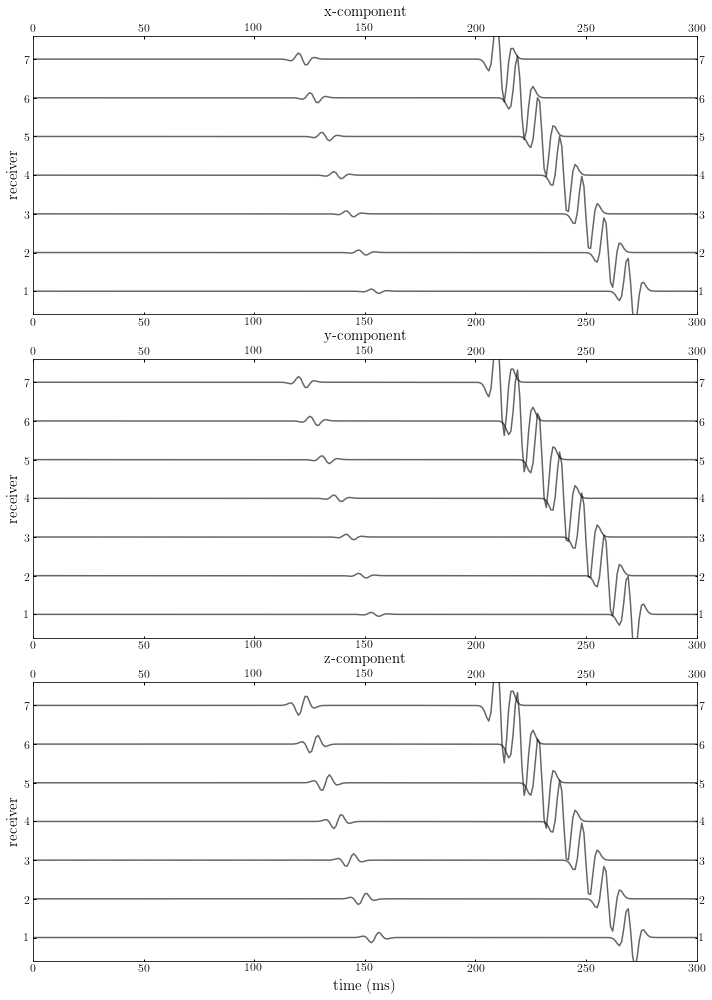

In [47]:
# path = 'gathers/';
# fdr_fig_  = "gathers/"
# filenames   = os.listdir(path)      ;  # list of all file names in folder in path
# num_files   = np.shape(filenames)[0];  # length of the list: number of files
# num_gathers = int(num_files/3);

num_gathers = 1
##########################################
##########################################
for i in range(num_gathers):
        iname     = str(i+1);
        print(iname)
        #filenamex = path+'datax.txt';
        #filenamey = path+'datay.txt';
        #filenamez = path+'dataz.txt';

        datax     = ux #np.loadtxt(filenamex)               ; # extract x-data.
        datay     = uy #np.loadtxt(filenamey)               ; # extract y-data.
        dataz     = uz #np.loadtxt(filenamez)               ; # extract z-data.
        [nsx,ntx] = np.shape(datax)                ; # dimension of x-data.
        print()
        print("dimension of x-data")
        print("number of samples   : ", nsx);
        print("number of traces    : ", ntx);
        [nsy,nty] = np.shape(datay)                ; # dimension of y-data.
        print()
        print("dimension of y-data")
        print("number of samples   : ", nsy);
        print("number of traces    : ", nty);
        [nsz,ntz] = np.shape(dataz)                ; # dimension of z-data.
        print()
        print("dimension of z-data")
        print("number of samples   : ", nsz);
        print("number of traces    : ", ntz);


        porc_norm = 0.99    # porcentage of normalize data.

        maximx   = np.amax(abs(datax))             ; # extract data maximum x normalization.
        maximy   = np.amax(abs(datay))             ; # extract data maximum x normalization.
        maximz   = np.amax(abs(dataz))             ; # extract data maximum x normalization.
        max      = np.amax([maximx,maximy,maximz]) ;

        datax    = datax/max                    ; # normalize
        datay    = datay/max                    ; # normalize
        dataz    = dataz/max                    ; # normalize

        datax    = datax*porc_norm                ; # take a porcentage of normalize data.
        datay    = datay*porc_norm                ; # take a porcentage of normalize data.
        dataz    = dataz*porc_norm                ; # take a porcentage of normalize data.

        ts = 0.0 ; # time begins in 0.0 ms
        te = 300.0;#nsx  ; # time ends at m ms

        # Because data is normalize to 1 (or porc of 1)
        # each trace occupies 2 vertical units (maximum).

        # we need at least 2*nt vertical space in ylim
        first_trace = 0        ;  # first trace is positioned at zero.
        last_trace  = 2*(ntx-1);  # (nt-1) : number of intervals between nt traces
        # 2*     : time 2, vertical space.
        minY  = (first_trace - 1) - 0.2 ;
        maxY  = (last_trace  + 1) + 0.2 ;

        lw     = 1.5;  # linewidth
        ls     = '-';  # linestyle
        alp    = 0.6;  # alpha ransparency for line
        xlab_s = 15;   # x-label size
        ylab_s = 15;   # y-label size
        tit_s  = 15;   # title size
        tic_s  = 12;   # tics size

        scale  = 3.0; # scales data (1.0: 0 scaling). Warn: makes data bigger.
        yticksnum     = np.linspace(first_trace,last_trace,ntx);                # y tick numbers
        ytickslabels  = np.tile(((np.linspace(1,ntx,ntx)).astype(np.int64)),1); # y tick labels

        fig2,ax2  = plt.subplots(figsize=(10,14));
        for i in range(ntx):
                # x-plot
                gath_X = scale*datax[:,i];
                gath_Y = scale*datay[:,i];
                gath_Z = scale*dataz[:,i];

                plt.subplot(3,1,1)
                plt.plot(gath_X  + 2*i,
                linestyle = ls,
                linewidth = lw,
                color     = 'black',
                alpha     = alp)
                left,right = plt.xlim()
                plt.xlim(left  = ts)  # adjust the left leaving right unchanged
                plt.xlim(right = te)  # adjust the right leaving left unchanged
                plt.tick_params(
                axis        = "y",
                width       = 1,
                length      = 2.5,
                direction   = "in",
                color       = "black",
                pad         = 2.5,
                labelsize   = tic_s,
                labelcolor  = "black",
                colors      = "black",
                zorder      = 20,
                bottom      = "on", top      = "off", left      = "on", right      = "off",
                labelbottom = "on", labeltop = "off", labelleft = "on", labelright = "off");
                bottom, top = plt.ylim()
                plt.ylim(bottom = minY)
                plt.ylim(top    = maxY)
                plt.yticks(yticksnum,ytickslabels);
                plt.tick_params(
                axis        = "x",
                width       = 1,
                length      = 2.5,
                direction   = "in",
                color       = "black",
                pad         = 2.5,
                labelsize   = tic_s,
                labelcolor  = "black",
                colors      = "black",
                zorder      = 20,
                bottom      = "on", top      = "off", left      = "on", right      = "off",
                labelbottom = "on", labeltop = "off", labelleft = "on", labelright = "off");
                plt.ylabel(r"receiver",fontsize   = ylab_s)
                plt.title(r"x-component",fontsize = tit_s)
                plt.subplot(3,1,2)
                # y-plot
                plt.plot(gath_Y  + 2*i,
                linestyle = ls,
                linewidth = lw,
                color     = 'black',
                alpha     = alp)
                left,right = plt.xlim()
                plt.xlim(left  = ts)  # adjust the left leaving right unchanged
                plt.xlim(right = te)  # adjust the right leaving left unchanged
                plt.tick_params(
                axis        = "y",
                width       = 1,
                length      = 2.5,
                direction   = "in",
                color       = "black",
                pad         = 2.5,
                labelsize   = tic_s,
                labelcolor  = "black",
                colors      = "black",
                zorder      = 20,
                bottom      = "on", top      = "off", left      = "on", right      = "off",
                labelbottom = "on", labeltop = "off", labelleft = "on", labelright = "off");
                bottom, top = plt.ylim()
                plt.ylim(bottom = minY)
                plt.ylim(top    = maxY)
                plt.yticks(yticksnum,ytickslabels);
                plt.tick_params(
                axis        = "x",
                width       = 1,
                length      = 2.5,
                direction   = "in",
                color       = "black",
                pad         = 2.5,
                labelsize   = tic_s,
                labelcolor  = "black",
                colors      = "black",
                zorder      = 20,
                bottom      = "on", top      = "off", left      = "on", right      = "off",
                labelbottom = "on", labeltop = "off", labelleft = "on", labelright = "off");
                plt.ylabel(r"receiver",fontsize   = ylab_s)
                plt.title(r"y-component",fontsize = tit_s)
                plt.subplot(3,1,3)
                # z-plot
                plt.plot(gath_Z  + 2*i,
                linestyle = ls,
                linewidth = lw,
                color     = 'black',
                alpha     = alp)
                left,right = plt.xlim()
                plt.xlim(left  = ts)  # adjust the left leaving right unchanged
                plt.xlim(right = te)  # adjust the right leaving left unchanged
                plt.tick_params(
                axis        = "y",
                width       = 1,
                length      = 2.5,
                direction   = "in",
                color       = "black",
                pad         = 2.5,
                labelsize   = tic_s,
                labelcolor  = "black",
                colors      = "black",
                zorder      = 20,
                bottom      = "on", top      = "off", left      = "on", right      = "off",
                labelbottom = "on", labeltop = "off", labelleft = "on", labelright = "off");
                bottom, top = plt.ylim()
                plt.ylim(bottom = minY)
                plt.ylim(top    = maxY)
                plt.yticks(yticksnum,ytickslabels);
                plt.tick_params(
                axis        = "x",
                width       = 1,
                length      = 2.5,
                direction   = "in",
                color       = "black",
                pad         = 2.5,
                labelsize   = tic_s,
                labelcolor  = "black",
                colors      = "black",
                zorder      = 20,
                bottom      = "on", top      = "off", left      = "on", right      = "off",
                labelbottom = "on", labeltop = "off", labelleft = "on", labelright = "off");
                plt.xlabel(r"time (ms)",fontsize  = xlab_s)
                plt.ylabel(r"receiver",fontsize   = ylab_s)
                plt.title(r"z-component",fontsize = tit_s)
                plt.tight_layout(w_pad=0.0,h_pad=0.2)

        # fname = fdr_fig_+'gather_xyz.png'
        # plt.savefig(fname, bbox_inches='tight',
        # dpi=300,
        # facecolor='w',
        # edgecolor='w',
        # orientation='portrait',
        # papertype=None,
        # transparent=False,
        # pad_inches=0.1,
        # frameon=None,
        # metadata=None)
        # fname = fdr_fig_+'gather_xyz_'+iname+'.eps'
        # plt.savefig(fname)
        plt.show()
        # plt.close(fig2)